# Setup

In [1]:
import os
from pathlib import Path
os.chdir(Path.cwd().parent)
# print("cwd is now:", Path.cwd())

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from data_loader import scores_df
from fit import fit_statistical_model
import statsmodels.api as sm
from scipy.stats import linregress
from scipy.optimize import least_squares
from typing import Union, Optional

In [3]:
anchor_benchmark = "Winogrande"
anchor_difficulty = 0
anchor_slope = 1

opt_df = scores_df[scores_df['optimized']]
df_opt, df_cm_opt, df_bd_opt = fit_statistical_model(opt_df, anchor_benchmark, anchor_difficulty, anchor_slope)

# Convert date strings to datetime objects
df_cm_opt['date_obj'] = pd.to_datetime(df_cm_opt['date'])

`ftol` termination condition is satisfied.
Function evaluations 34, initial cost 1.9883e+01, final cost 8.7495e-01, first-order optimality 3.52e-05.


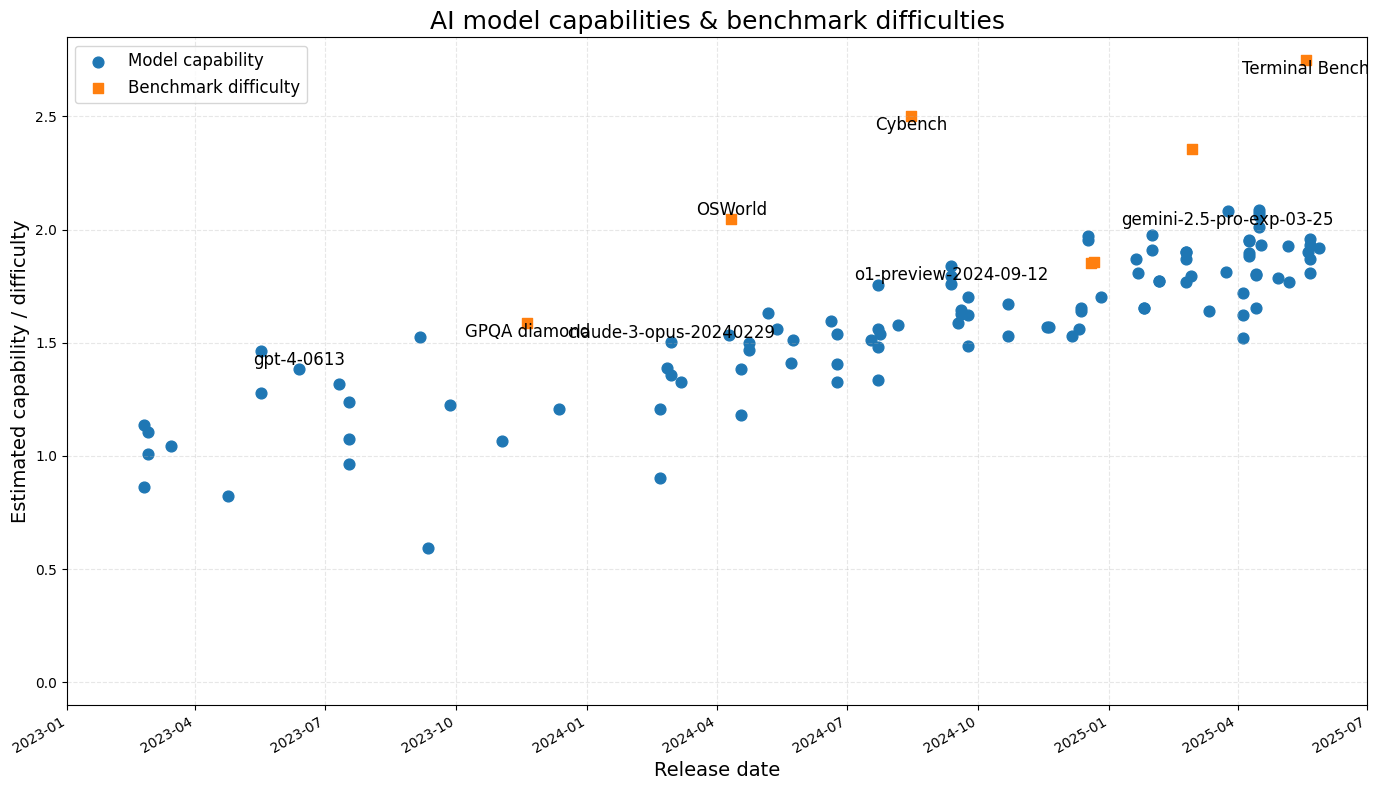

In [4]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm_opt.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_bd_opt.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()


Bootstrapped mean rate: 0.3271 capability units/year
95% confidence interval: [0.2687, 0.4028]


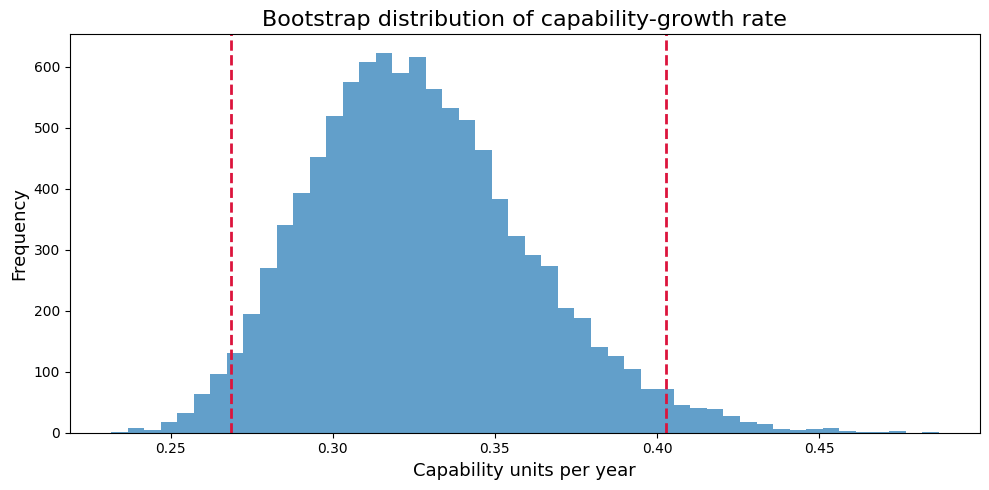

In [5]:
# ── 5) Bootstrap the slope ─────────────────────────────────────────────
import numpy as np

n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

x_full = cap_dates_num                       # days-since-0000-12-31 (float64)
y_full = cap_values.to_numpy()         # capability values (float64)

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.show()

In [6]:
anchor_benchmark = "Balrog"
anchor_difficulty = 0
anchor_slope = 1

unopt_df = scores_df[~scores_df['optimized']]
df_unopt, df_cm_unopt, df_bd_unopt = fit_statistical_model(unopt_df, anchor_benchmark, anchor_difficulty, anchor_slope)

# Convert date strings to datetime objects
df_cm_unopt['date_obj'] = pd.to_datetime(df_cm_unopt['date'])

`ftol` termination condition is satisfied.
Function evaluations 34, initial cost 4.0292e+00, final cost 2.6478e-01, first-order optimality 4.63e-05.


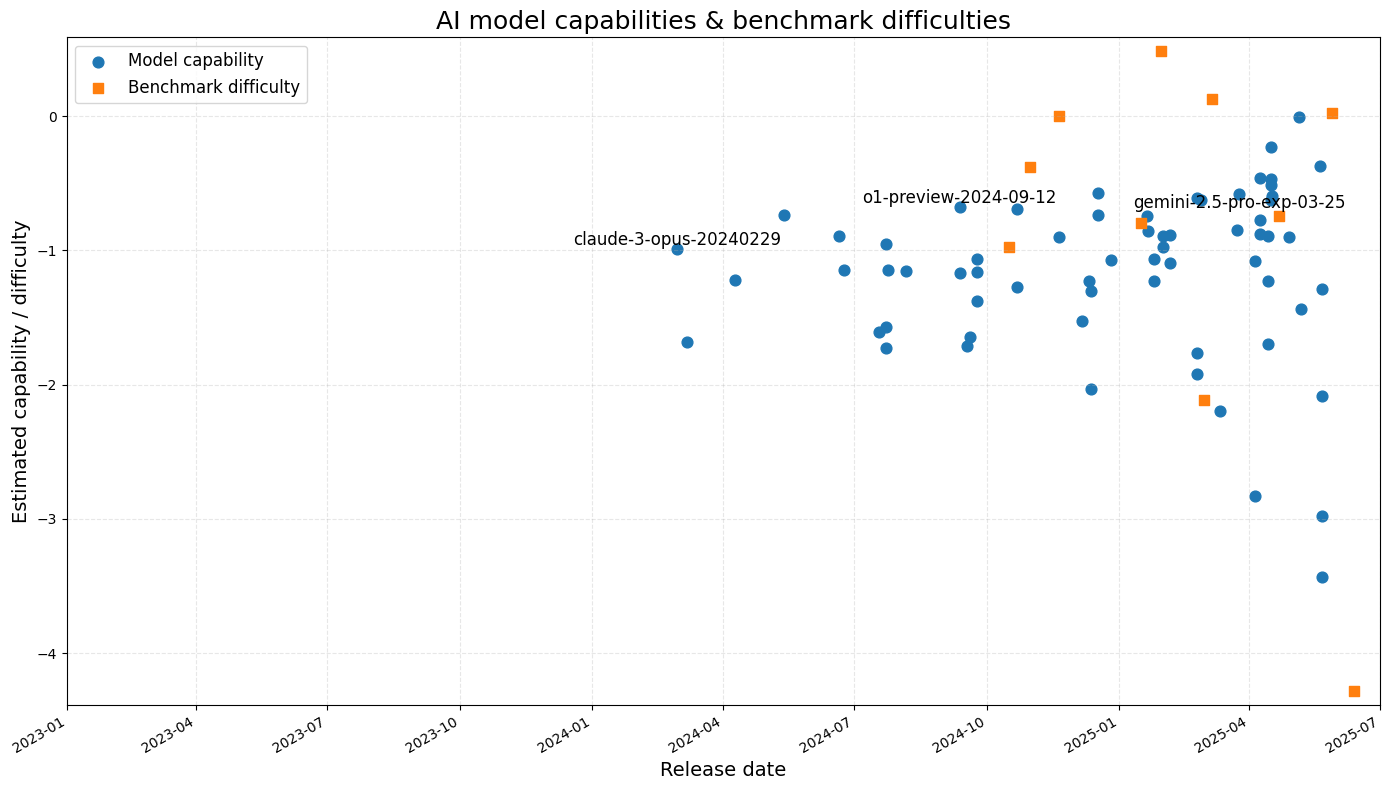

In [7]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
import pandas as pd

# ── 1)  PREP THE TWO DATA SETS ────────────────────────────────────────────
# --- models / capabilities
cap_df = df_cm_unopt.copy()
cap_df["date_obj"] = pd.to_datetime(cap_df["date_obj"])
cap_df.sort_values("date_obj", inplace=True, ignore_index=True)
cap_dates_num = mdates.date2num(cap_df["date_obj"])
cap_values    = cap_df["estimated_capability"]

# --- benchmarks / difficulties
bench_df = df_bd_unopt.copy()
bench_df["date_obj"] = pd.to_datetime(bench_df["benchmark_release_date"])
bench_df.sort_values("date_obj", inplace=True, ignore_index=True)
bench_dates_num = mdates.date2num(bench_df["date_obj"])
bench_values    = bench_df["estimated_difficulty"]

# ── 2)  PLOT BOTH SERIES ON ONE AXES ───────────────────────────────────────
fig, ax = plt.subplots(figsize=(14, 8))

cap_plot   = ax.scatter(cap_dates_num,   cap_values,
                        marker='o', s=60, color='tab:blue',  label='Model capability')
bench_plot = ax.scatter(bench_dates_num, bench_values,
                        marker='s', s=60, color='tab:orange', label='Benchmark difficulty')

# ── 3)  ANNOTATE SELECTED POINTS ───────────────────────────────────────────
annotate_models = {
    "gpt-4-0613",
    "claude-3-opus-20240229",
    "gemini-2.5-pro-exp-03-25",
    "o1-preview-2024-09-12",
}

for i, (d, y, name) in enumerate(zip(cap_dates_num, cap_values, cap_df["model"])):
    if name not in annotate_models:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

annotate_benchmarks = {
    "MMLU",
    "Winogrande",
    "GPQA diamond",
    "OSWorld",
    "Cybench",
    "Terminal Bench",
    "TriviaQA",
}

for i, (d, y, name) in enumerate(zip(bench_dates_num, bench_values, bench_df["benchmark_name"])):
    if name not in annotate_benchmarks:
        continue
    y_offset  = 0.05 if i % 2 == 0 else -0.05
    va        = 'bottom' if i % 2 == 0 else 'top'
    ax.annotate(name, xy=(d, y), xytext=(0, y_offset),
                textcoords='offset points', ha='center', va=va, fontsize=12)

# ── 4)  AXES COSMETICS & LEGEND ────────────────────────────────────────────
ax.set_xlabel("Release date",  fontsize=14)
ax.set_ylabel("Estimated capability / difficulty", fontsize=14)
ax.set_title("AI model capabilities & benchmark difficulties", fontsize=18)

# date ticks every 3 months
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
fig.autofmt_xdate()

# y-range covers both series
min_y = min(cap_values.min(),  bench_values.min()) - 0.1
max_y = max(cap_values.max(),  bench_values.max()) + 0.1
ax.set_ylim(min_y, max_y)

# x-range exactly as requested
ax.set_xlim(datetime(2023, 1, 1), datetime(2025, 7, 1))

ax.grid(True, linestyle='--', alpha=0.3)
ax.legend(fontsize=12)

plt.tight_layout()
plt.savefig("capabilities_and_benchmarks_over_time.pdf")
plt.show()


Bootstrapped mean rate: 0.0266 capability units/year
95% confidence interval: [-0.4675, 0.4926]


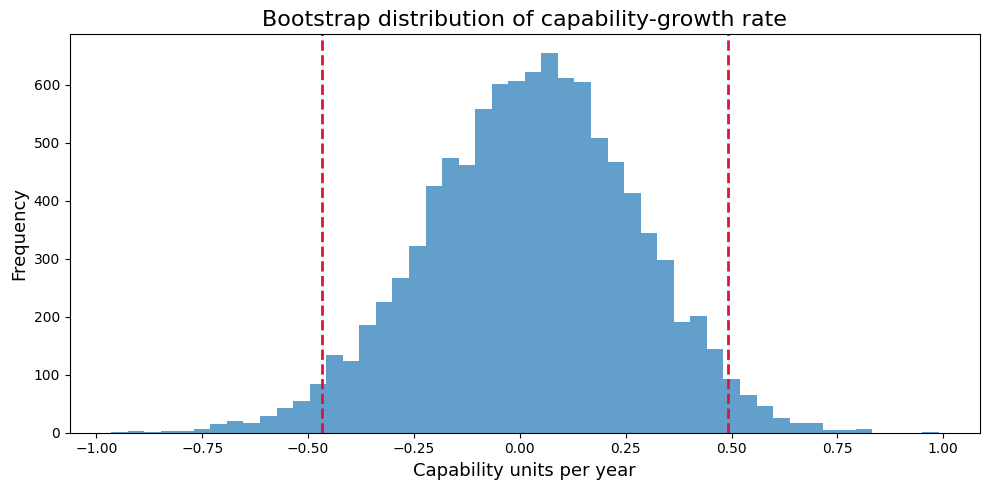

In [8]:
# ── 5) Bootstrap the slope ─────────────────────────────────────────────
import numpy as np

n_boot      = 10000          # number of bootstrap resamples
rng         = np.random.default_rng(0)   # reproducible seed

x_full = cap_dates_num                       # days-since-0000-12-31 (float64)
y_full = cap_values.to_numpy()         # capability values (float64)

boot_slopes_year = np.empty(n_boot)      # pre-allocate

for i in range(n_boot):
    # sample indices with replacement
    idx           = rng.choice(len(x_full), len(x_full), replace=True)
    slope_day, _  = np.polyfit(x_full[idx], y_full[idx], 1)
    boot_slopes_year[i] = slope_day * 365.25   # convert to per-year

# point estimate & 95 % CI
mean_rate = boot_slopes_year.mean()
ci_lower, ci_upper = np.percentile(boot_slopes_year, [2.5, 97.5])

print(f"Bootstrapped mean rate: {mean_rate:.4f} capability units/year")
print(f"95% confidence interval: [{ci_lower:.4f}, {ci_upper:.4f}]")

# ── (optional) visualise the bootstrap distribution ────────────────────
plt.figure(figsize=(10, 5))
plt.hist(boot_slopes_year, bins=50, alpha=0.7)
plt.axvline(ci_lower, color='crimson', linestyle='--', lw=2)
plt.axvline(ci_upper, color='crimson', linestyle='--', lw=2)
plt.title('Bootstrap distribution of capability-growth rate', fontsize=16)
plt.xlabel('Capability units per year', fontsize=13)
plt.ylabel('Frequency', fontsize=13)
plt.tight_layout()
plt.show()